# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
#Pardon the comments please!

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#We are using Imputer, available in pre-sklearb-2.0 versions
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
#Checked the .csv file, the data was separated by ; , so used the appropriate separator
#If we do not use appropriate separator, we will end up with Rachel's trifle

azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [4]:
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [5]:
print(azdias)

        AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0             -1                     2          1            2.0   
1             -1                     1          2            5.0   
2             -1                     3          2            3.0   
3              2                     4          2            2.0   
4             -1                     3          1            5.0   
5              3                     1          2            2.0   
6             -1                     2          2            5.0   
7             -1                     1          1            3.0   
8             -1                     3          1            3.0   
9             -1                     3          2            4.0   
10             0                     3          2            1.0   
11            -1                     2          1            6.0   
12            -1                     3          1            6.0   
13            -1                     1          

In [6]:
print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
#Checking the data type of the missing_or_unknown columns
print(feat_info['missing_or_unknown'].dtype)

object


In [8]:
#Parse over the missing_unknown column to get the list of numbers

def getListFromColumn(stringlist):
    #Remove the comma and closing brackets before parsing
    stringlist = stringlist[1:-1].split(',')

    result = []
    for s in stringlist:
        try:
            result.append(int(s))
        except:
            result.append(s)
    return result



In [9]:
feat_info['List_NA'] = feat_info['missing_or_unknown'].apply(getListFromColumn)

In [10]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown,List_NA
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [11]:
#What is the type of the new column created
print(feat_info['List_NA'].dtype)

object


In [12]:
# Index is like using primary key to access the database
# Like using multi-verse dimension number to access specific earth

att_index = feat_info.set_index('attribute')

print(att_index)


                      information_level         type missing_or_unknown  \
attribute                                                                 
AGER_TYP                         person  categorical             [-1,0]   
ALTERSKATEGORIE_GROB             person      ordinal           [-1,0,9]   
ANREDE_KZ                        person  categorical             [-1,0]   
CJT_GESAMTTYP                    person  categorical                [0]   
FINANZ_MINIMALIST                person      ordinal               [-1]   
FINANZ_SPARER                    person      ordinal               [-1]   
FINANZ_VORSORGER                 person      ordinal               [-1]   
FINANZ_ANLEGER                   person      ordinal               [-1]   
FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]   
FINANZ_HAUSBAUER                 person      ordinal               [-1]   
FINANZTYP                        person  categorical               [-1]   
GEBURTSJAHR              

In [13]:
#Now finally, replace the values!! I can do this all day!

#First make a copy to keep the mess separate
final_azdias = azdias[:] 


for column in final_azdias.columns:
    final_azdias[column].replace(att_index.loc[column].loc['List_NA'],np.NaN,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [14]:
final_azdias.head()

#Now I can see that the value NaN appears where original there were -1/0. So, it really worked.

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [15]:
#Now check how many values are Nan

final_azdias.isna().sum().sum()


8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Investigate patterns in the amount of missing data in each column.

na_by_column=final_azdias.isna().sum()

print(na_by_column)


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([      0. ,   88906.1,  177812.2,  266718.3,  355624.4,  444530.5,
         533436.6,  622342.7,  711248.8,  800154.9,  889061. ]),
 <a list of 10 Patch objects>)

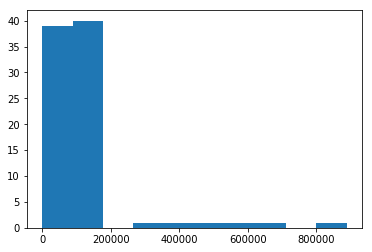

In [17]:
plt.hist(na_by_column)

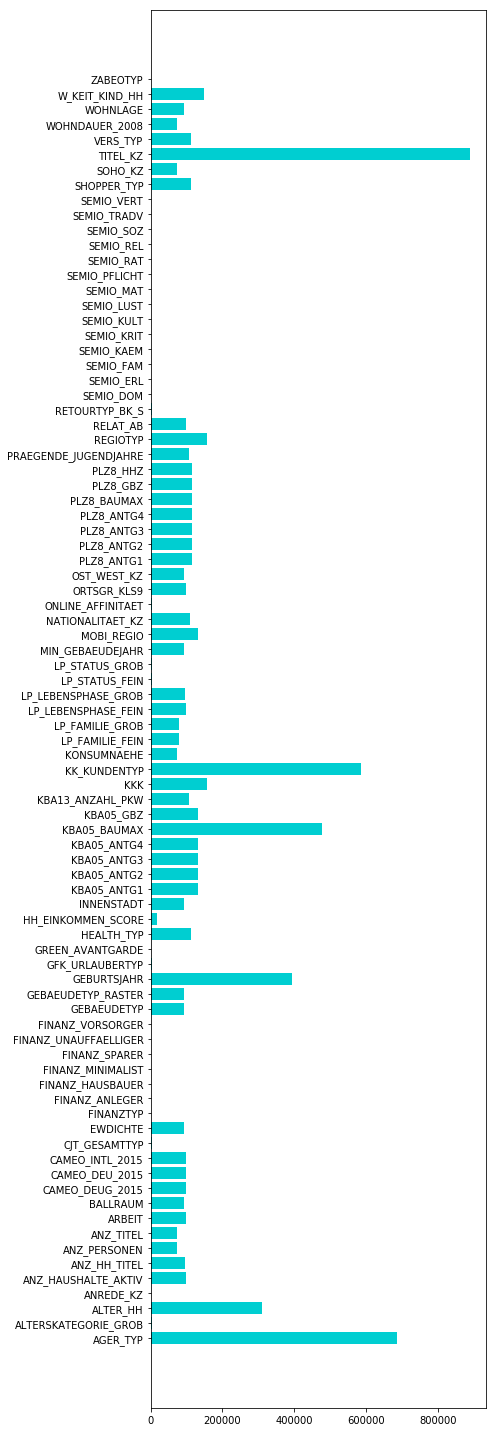

In [18]:
#This is much better way to visualize

plt.figure(figsize=(7,20))
barh = plt.barh( final_azdias.columns ,na_by_column,color = 'darkturquoise', alpha = 1)
plt.tight_layout()

In [19]:

# Remove the outlier columns from the dataset. (after re-encoding categorical features)
# From the histogram above, we better delete columnns with NAs more than 200000

#Get index of the columns which have 

outlier_columns = ['KBA05_BAUMAX', 'KK_KUNDENTYP', 'ALTER_HH' , 'TITEL_KZ' , 'GEBURTSJAHR' , 'AGER_TYP']
final_azdias.drop(labels=outlier_columns,axis=1,inplace=True)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [20]:
#Now have a look. Some columns have indeed been removed.

final_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

ANSWER:
With the help of the bar plot, I removed columns which had missing values >= 400000. These 6 columns stood out clearly in the bar plot which helped me decide the cut-off value of 400000.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?
na_by_rows = final_azdias.isna().sum(axis=1)

In [22]:
print(na_by_rows)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0. ,   4.9,   9.8,  14.7,  19.6,  24.5,  29.4,  34.3,  39.2,
         44.1,  49. ]),
 <a list of 10 Patch objects>)

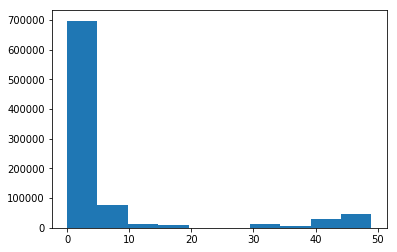

In [23]:
#Let us visualize the missing values for each of the rows
#plt.hist is the perfect for this job

plt.hist(na_by_rows)


In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#So, I will probably divide the data into these two parts. 

dataset_1 = final_azdias[na_by_rows < 30]
dataset_2 = final_azdias[na_by_rows > 30]


In [25]:
print(dataset_1.shape)

(798061, 79)


In [26]:
dataset_1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [27]:
dataset_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


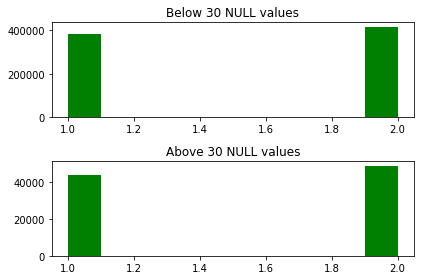

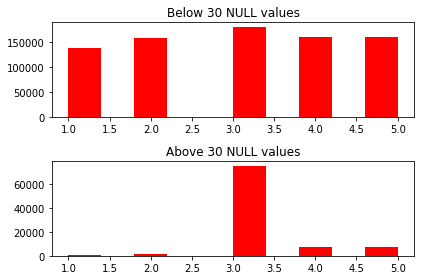

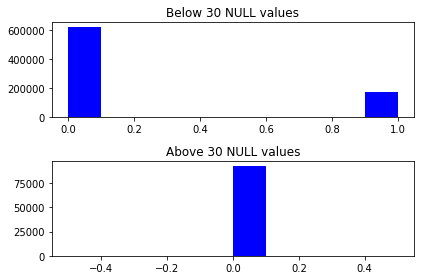

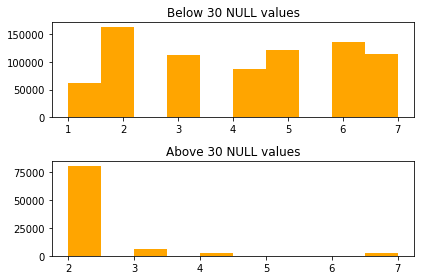

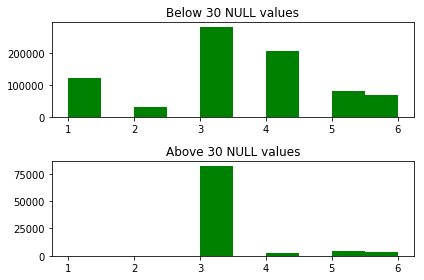

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

'''
I will be using these columns for comparison:

'ANREDE_KZ','FINANZ_MINIMALIST','GREEN_AVANTGARDE','SEMIO_SOZ','ZABEOTYP'

'''

def subplots(col, c):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(211)
    ax1.hist(dataset_1[col], color = c)
    ax1.set_title("Below 30 NULL values")
    ax2 = fig1.add_subplot(212)
    ax2.hist(dataset_2[col], color = c)
    ax2.set_title("Above 30 NULL values")
    fig1.tight_layout() #Increase spacing between the two axis
    plt.show()

comparing_columns = ['ANREDE_KZ','FINANZ_MINIMALIST','GREEN_AVANTGARDE','SEMIO_SOZ','ZABEOTYP']

colors = ['green', 'red', 'blue', 'orange','green']
for (i,c) in zip(comparing_columns,colors):
    subplots(i, c)




#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

ANSWER: 

In this section, we were able to deduce the two groups formed by the number of missing values. The bar plot shows this clearly wherein the two parts were (missing features < 30) and (missing features > 30).

For the column 'ANREDE_KZ', the distribution of values is identical in the two parts. On the other end, for the column 'GREEN_AVANTGARDE', the distirbutuion of values is totally different. For the rest of the columns, the distribution falls between the two limits.



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?

feat_info.groupby(['type'])['attribute'].count()


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# separating the multi level and binary categorical variable
multi_level = []
binary = []

categorical_variables = feat_info.loc[feat_info['type'] == 'categorical']

for feature in list(categorical_variables['attribute']):

    if len(azdias[feature].value_counts()) > 2:
        multi_level.append(feature)
    else:
        binary.append(feature)

In [31]:
print(multi_level)

['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [32]:
print(outlier_columns)

['KBA05_BAUMAX', 'KK_KUNDENTYP', 'ALTER_HH', 'TITEL_KZ', 'GEBURTSJAHR', 'AGER_TYP']


In [33]:
for x in multi_level:
    if x in outlier_columns:
        multi_level.remove(x)


In [34]:
print(multi_level)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [35]:
print(binary)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


In [36]:
final_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.

new_values = {'W': 0, 'O': 1}
final_azdias = final_azdias.replace({'OST_WEST_KZ':new_values})

In [38]:
final_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Answer:
I dropped the multi-level categorical variables to keep things simple. Also, I converted the column binary categorical column 'OST_WEST_KZ' with 'W' and 'O' values to the numeric values of 0 and 1.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

"PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" combines multiple information. All we have to do is separate it into multilpe columns.

Concept - https://knowledge.udacity.com/questions/115912

I will divide 'PRAEGENDE_JUGENDJAHRE' into 'PRAEGENDE_JUGENDJAHRE_DECADE' and 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'

In [39]:
final_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
final_azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [41]:
# create first new varibale: 'WHETHER_MAINSTREAM'
final_azdias.loc[final_azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'WHETHER_MAINSTREAM']=1
final_azdias.loc[final_azdias['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'WHETHER_MAINSTREAM']=2

# create second new varibale: 'Region': East-1, West-2, EAST+WEST-3
final_azdias.loc[final_azdias['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'REGION']=1
final_azdias.loc[final_azdias['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'REGION']=2
final_azdias.loc[final_azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'REGION']=3



In [42]:
final_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,WHETHER_MAINSTREAM,REGION
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,3.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,2.0,3.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1.0,3.0


In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

final_azdias['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [44]:

final_azdias['CAMEO_INTL_2015']=final_azdias['CAMEO_INTL_2015'].astype(float)

# create first new varibale: 'HOUSEHOLE_WEALTH'
final_azdias.loc[final_azdias['CAMEO_INTL_2015'].isin([51,52,53,54,55]),'HOUSEHOLE_WEALTH']=1
final_azdias.loc[final_azdias['CAMEO_INTL_2015'].isin([41,42,43,44,45]),'HOUSEHOLE_WEALTH']=2
final_azdias.loc[final_azdias['CAMEO_INTL_2015'].isin([31,32,33,34,35]),'HOUSEHOLE_WEALTH']=3
final_azdias.loc[final_azdias['CAMEO_INTL_2015'].isin([21,22,23,24,25]),'HOUSEHOLE_WEALTH']=4
final_azdias.loc[final_azdias['CAMEO_INTL_2015'].isin([11,12,13,14,15]),'HOUSEHOLE_WEALTH']=5

# create second new varibale: 'HOUSEHOLE_LIFE_STAGE'
final_azdias.loc[final_azdias['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'HOUSEHOLE_LIFE_STAGE']=1
final_azdias.loc[final_azdias['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'HOUSEHOLE_LIFE_STAGE']=2
final_azdias.loc[final_azdias['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'HOUSEHOLE_LIFE_STAGE']=3
final_azdias.loc[final_azdias['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'HOUSEHOLE_LIFE_STAGE']=4
final_azdias.loc[final_azdias['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'HOUSEHOLE_LIFE_STAGE']=5


# drop original column
#final_azdias.drop('CAMEO_INTL_2015',axis=1, inplace=True)

In [45]:
final_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,WHETHER_MAINSTREAM,REGION,HOUSEHOLE_WEALTH,HOUSEHOLE_LIFE_STAGE
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,3.0,1.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,1.0,4.0,4.0,3.0,5.0,2.0,2.0,3.0,4.0,4.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,1.0,3.0,4.0,2.0,3.0,3.0,1.0,3.0,5.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,3.0,3.0,4.0,6.0,5.0,1.0,3.0,2.0,3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Answer:
"PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" combines multiple information. Below is how I engineered these two features:

1. For the column 'PRAEGENDE_JUGENDJAHRE', I created two new columns that is, 'WHETHER_MAINSTREAM' and 'REGION'.
2. Based on two sets of initial value, I assigned WHETHER_MAINSTREAM two output values. (1,2).
3. Based on three sets of intial value, I assigned REGION three output values (1,2,3)
4. I then dropped the 'PRAEGENDE_JUGENDJAHRE' column.


1. For the column CAMEO_INTL_2015, I created two new columns, HOUSEHOLE_WEALTH and HOUSEHOLE_WEALTH.
2. Based on four sets of intial value, I assigned HOUSEHOLE_WEALTH five output values. (1,2,3,4,5)
3. Based on four sets of intial value, I assigned HOUSEHOLE_LIFE_STAGE five output values. (1,2,3,4,5)
4. I then dropped the CAMEO_INTL_2015 column.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
print(multi_level)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [47]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# drop original column
final_azdias.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
final_azdias.drop('CAMEO_INTL_2015',axis=1, inplace=True)

#I will be dropping the multi-level categorical variables completely to avoid mess
final_azdias.drop(labels=multi_level, axis = 1, inplace=True) 

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

## CLEANING FUNCTION STEPS
1. I have dropped the PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns. 
2. I have removed the multi-level categorical functions. 
3. I have encoded the binary categorical variable.
4. I have removed the outlier columns as well.

In [48]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(getListFromColumn)
    att_index = feat_info.set_index('attribute')
    for column in df.columns:
        df[column].replace(att_index.loc[column].loc['missing_or_unknown'],np.NaN,inplace=True)
    
    #Drop the outlier columns
    outlier_columns = ['KBA05_BAUMAX', 'KK_KUNDENTYP', 'ALTER_HH' , 'TITEL_KZ' , 'GEBURTSJAHR' , 'AGER_TYP']
    df.drop(labels=outlier_columns,axis=1,inplace=True)

    
    # Drop multi-level categorical variables.
    
    multi_level = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    df.drop(labels = multi_level ,axis=1,inplace=True)
    
    # select, re-encode, and engineer column values.
    
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'WHETHER_MAINSTREAM']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'WHETHER_MAINSTREAM']=2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]),'REGION']=1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]),'REGION']=2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]),'REGION']=3
    
    df['CAMEO_INTL_2015']=df['CAMEO_INTL_2015'].astype(float)

    # create first new varibale: 'HOUSEHOLE_WEALTH'
    df.loc[df['CAMEO_INTL_2015'].isin([51,52,53,54,55]),'HOUSEHOLE_WEALTH']=1
    df.loc[df['CAMEO_INTL_2015'].isin([41,42,43,44,45]),'HOUSEHOLE_WEALTH']=2
    df.loc[df['CAMEO_INTL_2015'].isin([31,32,33,34,35]),'HOUSEHOLE_WEALTH']=3
    df.loc[df['CAMEO_INTL_2015'].isin([21,22,23,24,25]),'HOUSEHOLE_WEALTH']=4
    df.loc[df['CAMEO_INTL_2015'].isin([11,12,13,14,15]),'HOUSEHOLE_WEALTH']=5

    # create second new varibale: 'HOUSEHOLE_LIFE_STAGE'
    df.loc[df['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'HOUSEHOLE_LIFE_STAGE']=1
    df.loc[df['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'HOUSEHOLE_LIFE_STAGE']=2
    df.loc[df['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'HOUSEHOLE_LIFE_STAGE']=3
    df.loc[df['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'HOUSEHOLE_LIFE_STAGE']=4
    df.loc[df['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'HOUSEHOLE_LIFE_STAGE']=5


    # drop the multi-information columns
    df.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
    df.drop('CAMEO_INTL_2015',axis=1, inplace=True)
    
    #Encode the binary categorical variables
    
    new_values = {'W': 0, 'O': 1}
    df = df.replace({'OST_WEST_KZ':new_values})
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

final_azdias.shape[0] - azdias.count()


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [50]:
final_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
RETOURTYP_BK_S           886367 non-null float64
SEMIO_SOZ                891221 non-null int64
SEMIO_FAM                891221 non-null int64
SEMIO_REL                891221 non-null int64
SEMIO_MAT                891221 non-null int64
SEMIO_VERT               891221 non-null int64
SEMIO_LUST               891221 n

In [51]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
data = imputer.fit_transform(final_azdias)


In [52]:
from sklearn.preprocessing import StandardScaler

# Standardizing
scaler = StandardScaler()
data = scaler.fit_transform(data)


In [53]:
final_azdias_2 = pd.DataFrame(data)
final_azdias_2.columns = final_azdias.columns

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Answer:
The strategy that I used for the Imputer was median, since I did not want to introduce float values. I used standard scaling so that each columns has a mean of 0 and a standard deviation of 1 .


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [54]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(final_azdias_2)



PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [55]:
pca.explained_variance_ratio_.sum()


0.99999999999999978

In [56]:
# Investigate the variance accounted for by each principal component.
pca.explained_variance_ratio_



array([  1.70080826e-01,   1.15664159e-01,   8.86718172e-02,
         5.53730356e-02,   4.10240894e-02,   3.30105342e-02,
         3.17817734e-02,   2.71937520e-02,   2.43349196e-02,
         2.15632812e-02,   2.00998063e-02,   1.99876679e-02,
         1.80048860e-02,   1.76014758e-02,   1.71812453e-02,
         1.62919502e-02,   1.55565528e-02,   1.49125446e-02,
         1.43467420e-02,   1.28165989e-02,   1.19478292e-02,
         1.14281612e-02,   1.12823208e-02,   1.09275955e-02,
         1.07058173e-02,   9.72065714e-03,   8.96146296e-03,
         8.26786036e-03,   7.51534800e-03,   7.12515128e-03,
         6.93165997e-03,   6.73785447e-03,   6.44783145e-03,
         6.27990992e-03,   6.14260506e-03,   5.88523741e-03,
         5.68807115e-03,   5.03894295e-03,   4.74278544e-03,
         4.69115953e-03,   4.36616089e-03,   4.07264964e-03,
         4.03151158e-03,   3.86968430e-03,   3.80038805e-03,
         3.68722329e-03,   3.54257815e-03,   3.37914896e-03,
         3.14547738e-03,

In [57]:


def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
            
            Credits to Udacity Nanodegree
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

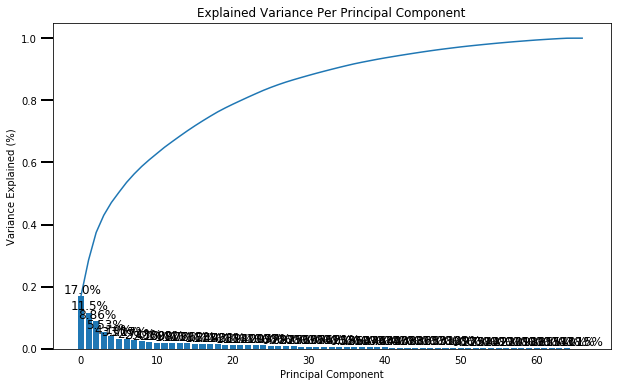

In [58]:
scree_plot(pca)


There are too many components. Let us limit the PCA components once they cross 90% variance.

In [59]:
number_of_pca_components = [25,30,40,50,60,70,80]

for n in number_of_pca_components:
    pca = PCA(n_components=n)
    pca.fit(final_azdias_2)
    if pca.explained_variance_ratio_.sum() >= 0.9:
        break



In [60]:
print(n)

40


In [61]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=n)
final_azdias_pca = pca.fit_transform(final_azdias_2)
pca.explained_variance_ratio_.sum()


0.93190627373939494

In [62]:
print(pca.components_)


[[-0.07470018  0.01435292 -0.19499951 ...,  0.01310945 -0.20479122
  -0.1178341 ]
 [ 0.29191054  0.07204387  0.11304842 ...,  0.02053456 -0.0265334
   0.02312697]
 [ 0.05670497 -0.35352159  0.14131817 ..., -0.03541512 -0.00099327
  -0.01308562]
 ..., 
 [ 0.00284964  0.11374409  0.06673609 ...,  0.03029736  0.13945605
  -0.04499173]
 [ 0.05652107 -0.09849114  0.03029262 ...,  0.02303558 -0.03454161
   0.01156157]
 [-0.07900021  0.0479193   0.0375067  ..., -0.02020348 -0.15454112
   0.02100394]]


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Answer:

I will be keeping n_components = 40, according to the above loop output. The variance of >90% is good enough.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [63]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

df=pd.DataFrame(pca.components_[0])
df.index=final_azdias_2.columns
df.columns=['PC_1']
df=df.sort_index(by=['PC_1'], ascending=False)
df



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


,PC_1
PLZ8_ANTG3,0.230214
PLZ8_ANTG4,0.224232
PLZ8_BAUMAX,0.211037
ORTSGR_KLS9,0.202521
EWDICHTE,0.201349
HH_EINKOMMEN_SCORE,0.172715
FINANZ_HAUSBAUER,0.167018
PLZ8_ANTG2,0.157385
KBA05_ANTG4,0.153066
ARBEIT,0.144642


In [64]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df=pd.DataFrame(pca.components_[1])
df.index=final_azdias_2.columns
df.columns=['PC_2']
df=df.sort_index(by=['PC_2'], ascending=False)
df


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  import sys


,PC_2
ALTERSKATEGORIE_GROB,0.291911
FINANZ_VORSORGER,0.262037
SEMIO_ERL,0.250740
SEMIO_LUST,0.197617
RETOURTYP_BK_S,0.172164
W_KEIT_KIND_HH,0.118184
FINANZ_MINIMALIST,0.113048
FINANZ_HAUSBAUER,0.087272
SEMIO_KRIT,0.074452
SEMIO_KAEM,0.073493


In [65]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

df=pd.DataFrame(pca.components_[2])
df.index=final_azdias_2.columns
df.columns=['PC_3']
df=df.sort_index(by=['PC_3'], ascending=False)
df


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  import sys


,PC_3
SEMIO_VERT,0.355091
SEMIO_SOZ,0.288882
SEMIO_KULT,0.268414
SEMIO_FAM,0.218618
FINANZ_MINIMALIST,0.141318
RETOURTYP_BK_S,0.087509
FINANZ_VORSORGER,0.075081
GREEN_AVANTGARDE,0.074832
WHETHER_MAINSTREAM,0.074832
PLZ8_BAUMAX,0.066743


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Answer:

The 1st PCA component has positive correlation with columns PLZ8_ANTG3, ORTSGR_KLS9,etc., that represents the size of the family. Also, it has negative correlation with MOBI_REGIO, that means as size of the family increases, movement increases.


The 2nd PCA component has a negative correlation with the HH_EINKOMMEN_SCORE,ARBEIT,ORTSGR_KLS9 and RELAT_AB, which indicate the prevalence of smaller community size, lower unemployment rate and higher household income.

The 3rd PCA component has a positive correlation with ALTERSKATEGORIE_GROB,SEMIO_ERL, SEMIO_LUST and SEMIO_KRIT and negative correlation with SEMIO_KULT,SEMIO_TRADV,SEMIO_REL, which indicates that this feature says something about age.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Text(0.5,1,'SSE vs. K')

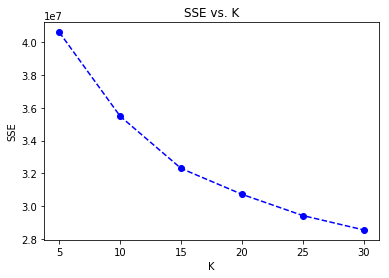

In [66]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
from sklearn.cluster import KMeans

def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center, max_iter=50)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
centers = [5,10,15,20,25,30]

for center in centers:
    scores.append(get_kmeans_score(final_azdias_pca, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')


In [67]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20)
kmeans_model = kmeans.fit(final_azdias_pca)
kmeans_label = kmeans_model.predict(final_azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Answer:

I decided to choose n_clusters = 20 based on the plot i.e., the average distance between the point to the center of the cluster, doesn't decrease significantly after n = 20.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#preprocess
clean_customers = clean_data(customers, feat_info)

In [69]:
clean_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB     191412 non-null float64
ANREDE_KZ                191652 non-null int64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               142662 non-null float64
LP_LEBENSPHASE_FEIN      140599 non-null float64
LP_LEBENSPHASE_GROB      140711 non-null float64
RETOURTYP_BK_S           188439 non-null float64
SEMIO_SOZ                191652 non-null int64
SEMIO_FAM                191652 non-null int64
SEMIO_REL                191652 non-null int64
SEMIO_MAT                191652 non-null int64
SEMIO_VERT               191652 non-null int64
SEMIO_LUST               191652 n

In [70]:
#take care of Nan and standardization

imputer_data = imputer.transform(clean_customers)
scaled_data = scaler.transform(imputer_data)

#Overcome the curse of dimensionality
customer_pca = pca.transform(scaled_data)

kmeans_label_customers = kmeans_model.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

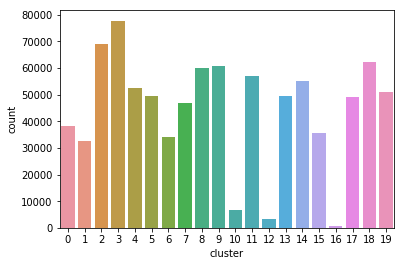

In [71]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_clusters_label=pd.DataFrame(kmeans_label)
general_clusters_label.columns=['cluster']

import seaborn as sns
sns.countplot(x = 'cluster',data=general_clusters_label)


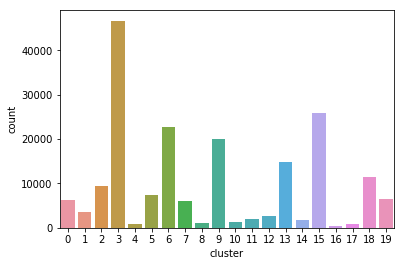

In [72]:
customer_clusters_label=pd.DataFrame(kmeans_label_customers)
customer_clusters_label.columns=['cluster']


import seaborn as sns
sns.countplot( x='cluster',data=customer_clusters_label)

Text(0.5,1,'General population')

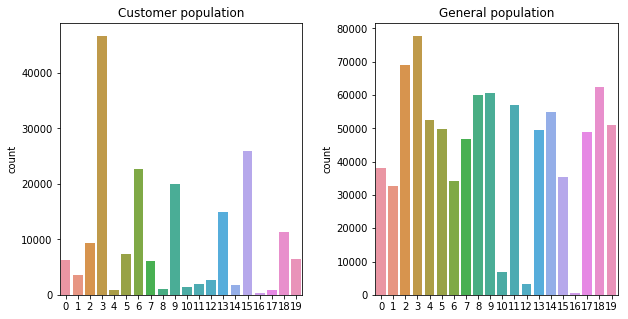

In [73]:
#Plotting the two together
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(kmeans_label_customers, ax=axs[0])
axs[0].set_title('Customer population')
sns.countplot(kmeans_label, ax=axs[1])
axs[1].set_title('General population')

We can see from the above plot that the cluster=10 is 'over-represented' and the cluster=5 is 'under-represented' in the CUSTOMER POPULATION when compared to the GENERAL POPULATION.

Let us inspect what pca components this cluster10 and cluster5 comprises of.

In [74]:
centroid_customer = kmeans_model.cluster_centers_[10]
centroid_customer_df = pd.DataFrame(centroid_customer,columns=['pca_weights'])
centroid_customer_df.reindex(centroid_customer_df.abs().sort_values(by='pca_weights',ascending=False).index).head()


,pca_weights
17,11.249758
18,-0.861739
16,-0.663992
7,-0.425003
0,-0.370655


Cluster 10 has a negative correlation with PCA components 0 and positive correlation with PCA components 4. Let us again see what is PCA[0] and PCA[4]

In [75]:
df=pd.DataFrame(pca.components_[0])
df.index=final_azdias_2.columns
df.columns=['PC_1']
df=df.sort_index(by=['PC_1'], ascending=False)
df


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


,PC_1
PLZ8_ANTG3,0.230214
PLZ8_ANTG4,0.224232
PLZ8_BAUMAX,0.211037
ORTSGR_KLS9,0.202521
EWDICHTE,0.201349
HH_EINKOMMEN_SCORE,0.172715
FINANZ_HAUSBAUER,0.167018
PLZ8_ANTG2,0.157385
KBA05_ANTG4,0.153066
ARBEIT,0.144642


In [76]:
df=pd.DataFrame(pca.components_[4])
df.index=final_azdias_2.columns
df.columns=['PC_5']
df=df.sort_index(by=['PC_5'], ascending=False)
df


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


,PC_5
LP_LEBENSPHASE_GROB,0.345902
ANZ_PERSONEN,0.329687
LP_LEBENSPHASE_FEIN,0.327460
KKK,0.220301
OST_WEST_KZ,0.216205
ONLINE_AFFINITAET,0.169379
REGIOTYP,0.160675
WOHNLAGE,0.145545
PLZ8_BAUMAX,0.113203
ARBEIT,0.107437


The 1st PCA component has positive correlation with columns PLZ8_ANTG3, ORTSGR_KLS9,etc., that represents the size of the family. Also, it has negative correlation with MOBI_REGIO, that means as size of the family increases, movement increases.

The 5th PCA component has positive correlation with columns LP_LEBENSPHASE_GROB, ANZ_PERSONEN and ngative correlation with KBA13_ANZAHL_PKW. This tells us about the personality/age of the person.

Since the cluster 10 is negatively influenced by 1st PCA and positively influenced by 5th PCA, cluster10 hints at well-settled older people in Germany.

In [77]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_customer = kmeans_model.cluster_centers_[5]
centroid_customer_df = pd.DataFrame(centroid_customer,columns=['pca_weights'])
centroid_customer_df.reindex(centroid_customer_df.abs().sort_values(by='pca_weights',ascending=False).index).head()


,pca_weights
0,2.988102
2,2.881622
1,1.881456
6,-1.040465
7,-0.773994


In [78]:
df=pd.DataFrame(pca.components_[2])
df.index=final_azdias_2.columns
df.columns=['PC_3']
df=df.sort_index(by=['PC_3'], ascending=False)
df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


,PC_3
SEMIO_VERT,0.355091
SEMIO_SOZ,0.288882
SEMIO_KULT,0.268414
SEMIO_FAM,0.218618
FINANZ_MINIMALIST,0.141318
RETOURTYP_BK_S,0.087509
FINANZ_VORSORGER,0.075081
GREEN_AVANTGARDE,0.074832
WHETHER_MAINSTREAM,0.074832
PLZ8_BAUMAX,0.066743


The 3rd PCA component has positive correlation with columns SEMIO_VERT, FINANZ_MINIMALIST and negative correlation with SEMIO_SOZ. 

Since the cluster 5 is positively influenced by 1st PCA and positively influenced by 3rd PCA, cluster5 hints at young and moving parts of the population

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

ANSWER:

We can see from the above plot that the cluster=10 is 'over-represented' and the cluster=5 is 'under-represented' in the CUSTOMER POPULATION when compared to the GENERAL POPULATION.

OVER_REPRESENTATION, cluster=10

1a) The cluster 10 is negatively influenced by 1st PCA and positively influenced by 5th PCA. Let's take a look at these PCA in details: 

- The 1st PCA component has positive correlation with columns PLZ8_ANTG3, ORTSGR_KLS9,etc., that represents the size of the family. Also, it has negative correlation with MOBI_REGIO, that means as size of the family increases, movement increases.

- The 5th PCA component has positive correlation with columns LP_LEBENSPHASE_GROB, ANZ_PERSONEN and ngative correlation with KBA13_ANZAHL_PKW. This tells us about the personality/age of the person.

1b) Thus, based on 1st and 5th PCA, cluster10 hints at well-settled older people in Germany.


UNDER_REPRESENTAION, cluster=5

2a) The cluster 5 is is positively influenced by 1st PCA and positively influenced by 3rd PCA. Let's take a look at these PCA in details:

- The 1st PCA component has positive correlation with columns PLZ8_ANTG3, ORTSGR_KLS9,etc., that represents the size of the family. Also, it has negative correlation with MOBI_REGIO, that means as size of the family increases, movement increases.

- The 3rd PCA component has positive correlation with columns SEMIO_VERT, FINANZ_MINIMALIST and negative correlation with SEMIO_SOZ. 

2b) Thus, based on 1st and 3rd PCA, cluster5 hints at young and moving parts of the population


To re-iterate,

Segments of the population that are relatively popular with the mail-order company(cluster 10): most of them are middle aged and elderly people（30-60 years old),typical house owners,household income level is average.

Segments of the population that are relatively unpopular with the mail-order company:(cluster 5): most of them are middle aged and elderly single male（30-60 years old), low income earners.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.